## Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

In [2]:
sns.set(style="whitegrid")

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

## Data Import


In [3]:
train = pd.read_parquet("data/train_data.parquet", engine="fastparquet")
test = pd.read_parquet("data/test_data.parquet", engine="fastparquet")

In [4]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    train.iloc[:, :-2],
    train.iloc[:, -1:],
    test_size=0.80,
    random_state=42,
    stratify=train.iloc[:, -1:],
)
X_test_sample, _, y_test_sample, _ = train_test_split(
    test.iloc[:, :-2],
    test.iloc[:, -1:],
    test_size=0.80,
    random_state=42,
    stratify=test.iloc[:, -1:],
)

## Functions


In [5]:
def plot_cm(cm, classes, title="Confusion Matrix", normalize=False):
    """Plots the confusion matrix as heatmap

    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
    classes : List[str]
        array of class labels
    title : str, optional
        Title of the heatmap, by default "Confusion Matrix"
    normalize : bool, optional
        If True, normalizes the confusion matrix, by default False

    Returns
    -------
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fmt = ".3f" if normalize else "g"
    sns.heatmap(
        cm,
        annot=True,
        cmap="BuPu",
        fmt=fmt,
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
    plt.show()

    return cm

In [6]:
def perform_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    classes,
    _plot_cm=False,
    _print_cr=False,
    _cm_normalize=True,
):
    """Performs the following steps in sequence
    1. Trains the model
    2. Predicts the test data
    3. Calculates the accuracy score
    4. Plots the confusion matrix
    5. Prints the classification report

    Parameters
    ----------
    model : estimator object
        The object to use to fit the data.
    X_train : ArrayLike
        Training data
    y_train : ArrayLike
        True labels for X_train
    X_test : ArrayLike
        Testing data
    y_test : ArrayLike
        True labels for X_test
    classes : List[str]
        array of class labels
    cm_normalize : bool, optional
        If True, normalizes the confusion matrix, by default True
    print_cr : bool, optional
        If True, prints the classification report, by default False

    Returns
    -------
    res : dict
        Dictionary containing the results of the model
    """
    res = {}

    start_time = datetime.now()
    model.fit(X_train, y_train)
    res["train_time"] = datetime.now() - start_time
    print(f"==> Train time:- {res['train_time']}")

    start_time = datetime.now()
    y_pred = model.predict(X_test)
    res["test_time"] = datetime.now() - start_time
    print(f"==> Test time:- {res['test_time']}")
    res["predicted"] = y_pred

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    res["accuracy"] = accuracy
    print(f"==> Accuracy:- {accuracy}")
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
    res["f1_score"] = f1
    print(f"==> F1 Score:- {f1}")

    cm = confusion_matrix(y_test, y_pred)
    res["confusion_matrix"] = cm
    if _plot_cm:
        plot_cm(cm, classes, normalize=_cm_normalize)

    cr = classification_report(y_test, y_pred)
    res["classification_report"] = cr
    if _print_cr:
        print("Classification Report")
        print(cr)

    res["model"] = model

    return res

In [7]:
def print_grid_search_attributes(model):
    """Prints the GridSearch attributes of the model

    Parameters
    ----------
    model : estimator object
    """
    print("==> Best parameters:")
    print(f"\tParameters of best estimator : {model.best_params_}")
    print("==> No. of CrossValidation sets:")
    print(f"\tTotal number of cross validation sets: {model.n_splits_}")
    print("==> Best Score:")
    print(f"\tAverage Cross Validate scores of best estimator : {model.best_score_}")

## Data Preperation


In [8]:
X_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
X_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]

labels = train["activity"].unique()
activities_encoder = LabelEncoder()
y_train = activities_encoder.fit_transform(y_train)
y_test = activities_encoder.transform(y_test)

PCA


In [35]:
pca = PCA(n_components=170)
X_train_lr_pca = pca.fit_transform(X_train)
X_test_lr_pca = pca.transform(X_test)

In [40]:
pca = PCA(n_components=70)
X_train_rf_pca = pca.fit_transform(X_train)
X_test_rf_pca = pca.transform(X_test)

In [46]:
pca = PCA(n_components=200)
X_train_svc_pca = pca.fit_transform(X_train)
X_test_svc_pca = pca.transform(X_test)

RFE


In [17]:
rfe = RFE(LogisticRegression(), step=10, n_features_to_select=180)
rfe.fit(X_train, y_train)
lr_selected_features = X_train.columns[rfe.support_]

In [9]:
rfe = RFE(RandomForestClassifier(), step=50, n_features_to_select=360)
rfe.fit(X_train, y_train)
rf_selected_features = X_train.columns[rfe.support_]

In [ ]:
rfe = RFE(LinearSVC(), step=10, n_features_to_select=70)
rfe.fit(X_train, y_train)
svc_selected_features = X_train.columns[rfe.support_]

VT


In [26]:
vt = VarianceThreshold(threshold=0.03)
vt.fit(X_train)
X_train_vt = vt.transform(X_train)
X_test_vt = vt.transform(X_test)

PCA + RFE


In [21]:
pca = PCA(n_components=150)
X_train_lr_rfepca = pca.fit_transform(X_train[lr_selected_features])
X_test_lr_rfepca = pca.transform(X_test[lr_selected_features])

In [11]:
pca = PCA(n_components=65)
X_train_rf_rfepca = pca.fit_transform(X_train[rf_selected_features])
X_test_rf_rfepca = pca.transform(X_test[rf_selected_features])

In [30]:
pca = PCA(n_components=45)
X_train_svc_rfepca = pca.fit_transform(X_train[svc_selected_features])
X_test_svc_rfepca = pca.transform(X_test[svc_selected_features])

## Models


### Logistic Regression


In [18]:
lr_parameters = {"C": [0.1, 0.25, 0.5, 1, 10, 20, 30], "penalty": ["l2", "l1"]}

Base


In [60]:
lr_grid = GridSearchCV(
    LogisticRegression(), param_grid=lr_parameters, cv=3, verbose=1, n_jobs=-1
)
lr_grid_results = perform_model(
    lr_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(lr_grid_results["model"])

Fitting 3 folds for each of 14 candidates, totalling 42 fits
==> Train time:- 0:00:13.321240
==> Test time:- 0:00:00.012000
==> Accuracy:- 0.9582626399728538
==> F1 Score:- 0.9581227725191673
==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9371615639319785


w/ RFE selection


Fitting 3 folds for each of 14 candidates, totalling 42 fits
==> Train time:- 0:00:05.024349
==> Test time:- 0:00:00.002997
==> Accuracy:- 0.9606379368849678
==> F1 Score:- 0.9605252375236596


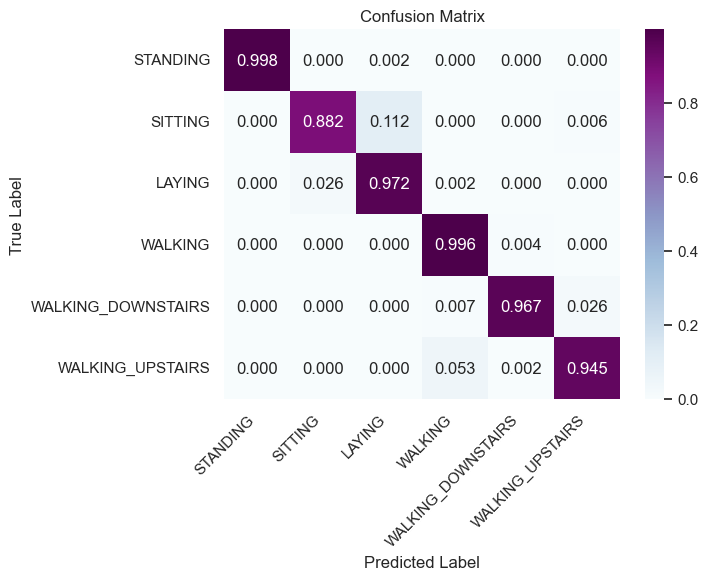

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.952531550359842


In [19]:
rfe_lr_grid = GridSearchCV(
    LogisticRegression(), param_grid=lr_parameters, cv=3, verbose=1, n_jobs=-1
)
rfe_lr_grid_results = perform_model(
    rfe_lr_grid,
    X_train[lr_selected_features],
    y_train,
    X_test[lr_selected_features],
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(rfe_lr_grid_results["model"])

w/ VT


In [62]:
vt_lr_grid = GridSearchCV(
    LogisticRegression(), param_grid=lr_parameters, cv=3, verbose=1, n_jobs=-1
)
vt_lr_grid_results = perform_model(
    vt_lr_grid,
    X_train_vt,
    y_train,
    X_test_vt,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(vt_lr_grid_results["model"])

Fitting 3 folds for each of 14 candidates, totalling 42 fits
==> Train time:- 0:00:07.755368
==> Test time:- 0:00:00.006999
==> Accuracy:- 0.9613165931455717
==> F1 Score:- 0.9611765321908495
==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.939609988426215


w/ PCA


In [63]:
pca_lr_grid = GridSearchCV(
    LogisticRegression(), param_grid=lr_parameters, cv=3, verbose=1, n_jobs=-1
)
pca_lr_grid_results = perform_model(
    pca_lr_grid,
    X_train_lr_pca,
    y_train,
    X_test_lr_pca,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(pca_lr_grid_results["model"])

Fitting 3 folds for each of 14 candidates, totalling 42 fits
==> Train time:- 0:00:03.421085
==> Test time:- 0:00:00.003000
==> Accuracy:- 0.9599592806243638
==> F1 Score:- 0.9598133736274128
==> Best parameters:
	Parameters of best estimator : {'C': 20, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9390663813465002


w/ RFE + PCA


Fitting 3 folds for each of 14 candidates, totalling 42 fits
==> Train time:- 0:00:02.602296
==> Test time:- 0:00:00.002340
==> Accuracy:- 0.9616559212758737
==> F1 Score:- 0.9615377320037758


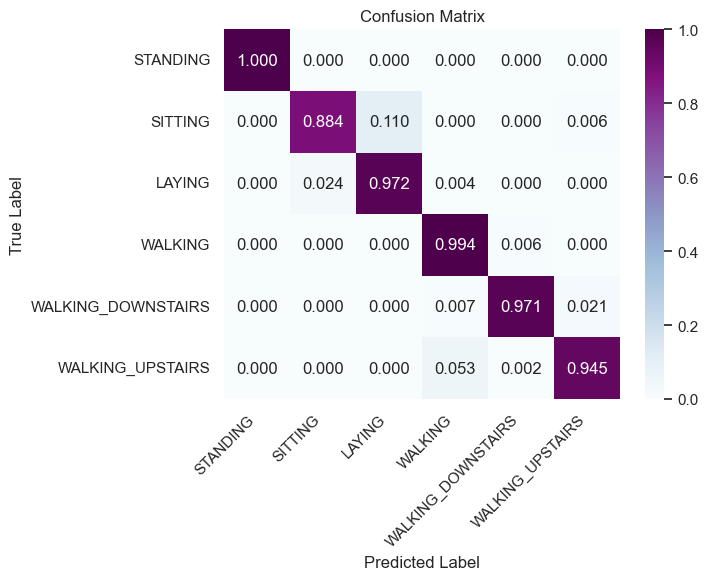

==> Best parameters:
	Parameters of best estimator : {'C': 10, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9536199857339916


In [22]:
rfepca_lr_grid = GridSearchCV(
    LogisticRegression(), param_grid=lr_parameters, cv=3, verbose=1, n_jobs=-1
)
rfepca_lr_grid_results = perform_model(
    rfepca_lr_grid,
    X_train_lr_rfepca,
    y_train,
    X_test_lr_rfepca,
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(rfepca_lr_grid_results["model"])

### Random Forest Classifier


In [12]:
rf_parameters = {
    "n_estimators": np.arange(50, 150, 20),
    "max_depth": np.arange(5, 9, 2),
}

In [66]:
rf_grid = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_parameters, cv=3, verbose=1, n_jobs=-1
)
rf_grid_results = perform_model(
    rf_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(rf_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:46.443323
==> Test time:- 0:00:00.027002
==> Accuracy:- 0.9151679674244995
==> F1 Score:- 0.9146288126750833
==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 70}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9141736955900271


RFE


Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:34.964641
==> Test time:- 0:00:00.030347
==> Accuracy:- 0.9049881235154394
==> F1 Score:- 0.9045710558836655


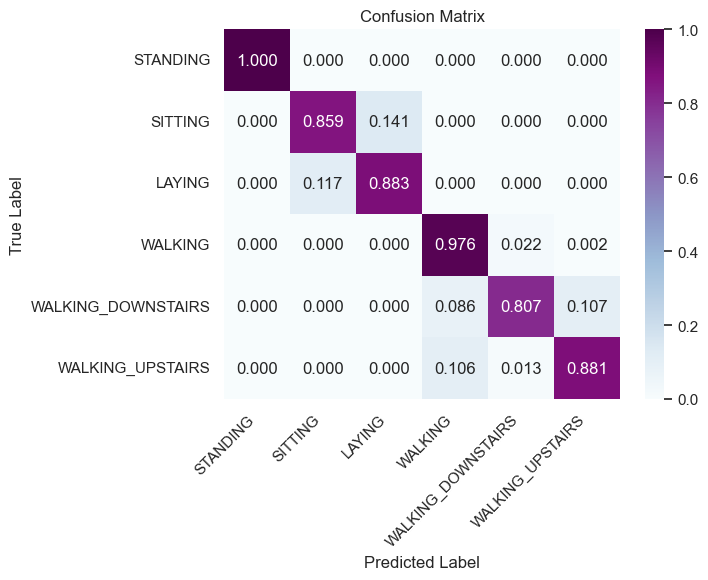

==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 90}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9107722795360494


In [13]:
rfe_rf_grid = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_parameters, cv=3, verbose=1, n_jobs=-1
)
rfe_rf_grid_results = perform_model(
    rfe_rf_grid,
    X_train[rf_selected_features],
    y_train,
    X_test[rf_selected_features],
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(rfe_rf_grid_results["model"])

PCA


In [68]:
pca_rf_grid = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_parameters, cv=3, verbose=1, n_jobs=-1
)
pca_rf_grid_results = perform_model(
    pca_rf_grid,
    X_train_rf_pca,
    y_train,
    X_test_rf_pca,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(pca_rf_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


==> Train time:- 0:00:20.985360
==> Test time:- 0:00:00.039030
==> Accuracy:- 0.8724126230064473
==> F1 Score:- 0.8715556907372564
==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 110}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.85609533246183


VT


In [ ]:
vt_rf_grid = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_parameters, cv=3, verbose=1, n_jobs=-1
)
vt_rf_grid_results = perform_model(
    vt_rf_grid,
    X_train_vt,
    y_train,
    X_test_vt,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(vt_rf_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:44.240814
==> Test time:- 0:00:00.038998
==> Accuracy:- 0.9070240922972514
==> F1 Score:- 0.9066440038448509
==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 110}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9095483448377312


RFE+PCA


Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:18.028332
==> Test time:- 0:00:00.039001
==> Accuracy:- 0.8778418730912793
==> F1 Score:- 0.8759526852051998


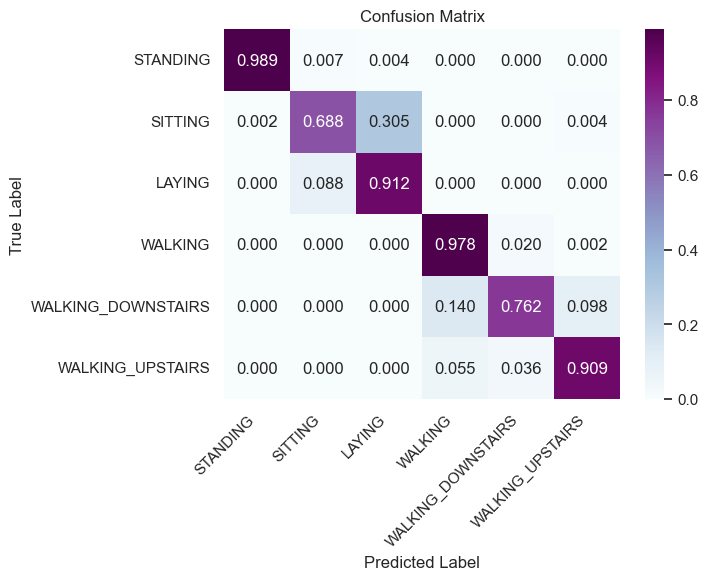

==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 130}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.8819364024679639


In [14]:
rfepca_rf_grid = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_parameters, cv=3, verbose=1, n_jobs=-1
)
rfepca_rf_grid_results = perform_model(
    rfepca_rf_grid,
    X_train_rf_rfepca,
    y_train,
    X_test_rf_rfepca,
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(rfepca_rf_grid_results["model"])

### Linear SVC


In [71]:
svc_parameters = {"C": [0.125, 0.5, 1, 2, 4], "penalty": ["l2", "l1"]}

base


In [72]:
svc_grid = GridSearchCV(
    LinearSVC(), param_grid=svc_parameters, cv=3, verbose=1, n_jobs=-1
)
svc_grid_results = perform_model(
    svc_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(svc_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


==> Train time:- 0:00:18.410877
==> Test time:- 0:00:00.007002
==> Accuracy:- 0.9670851713607058
==> F1 Score:- 0.9669065174364727
==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9470918714282939


RFE


Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:01.937027
==> Test time:- 0:00:00.002973
==> Accuracy:- 0.9484221241940957
==> F1 Score:- 0.9481959950345098


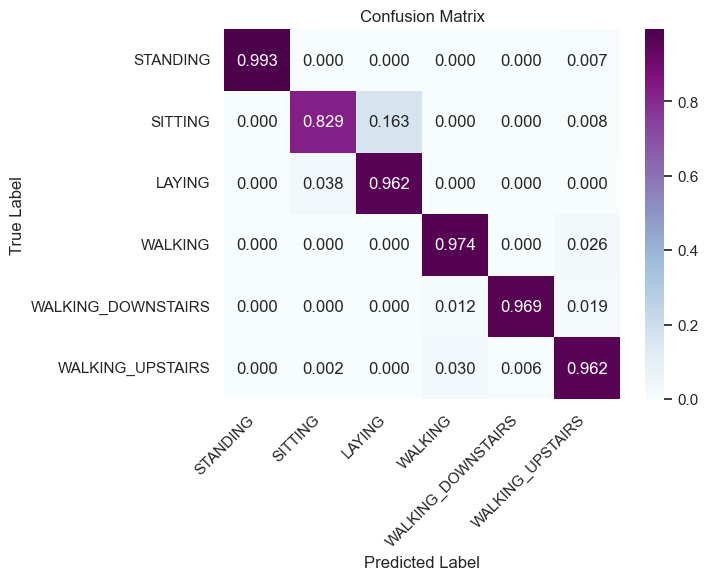

==> Best parameters:
	Parameters of best estimator : {'C': 4, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9601491547251295


In [73]:
svc_grid = GridSearchCV(
    LinearSVC(), param_grid=svc_parameters, cv=3, verbose=1, n_jobs=-1
)
svc_grid_results = perform_model(
    svc_grid,
    X_train[svc_selected_features],
    y_train,
    X_test[svc_selected_features],
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(svc_grid_results["model"])

PCA


In [74]:
pca_svc_grid = GridSearchCV(
    LinearSVC(), param_grid=svc_parameters, cv=3, verbose=1, n_jobs=-1
)
pca_svc_grid_results = perform_model(
    pca_svc_grid,
    X_train_svc_pca,
    y_train,
    X_test_svc_pca,
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=False,
)

print_grid_search_attributes(pca_svc_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:04.171433
==> Test time:- 0:00:00.004003
==> Accuracy:- 0.9657278588394977
==> F1 Score:- 0.9654694734302237
==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9432836798530101


VT


In [75]:
vt_svc_grid = GridSearchCV(
    LinearSVC(), param_grid=svc_parameters, cv=3, verbose=1, n_jobs=-1
)
vt_svc_grid_results = perform_model(
    vt_svc_grid,
    X_train_vt,
    y_train,
    X_test_vt,
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=False,
)

print_grid_search_attributes(vt_svc_grid_results["model"])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:13.839662
==> Test time:- 0:00:00.004999
==> Accuracy:- 0.9684424838819138
==> F1 Score:- 0.9682712389585675
==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9446435579535772


RFE+PCA


Fitting 3 folds for each of 10 candidates, totalling 30 fits
==> Train time:- 0:00:01.003157
==> Test time:- 0:00:00.002001
==> Accuracy:- 0.9531727180183237
==> F1 Score:- 0.9528737199028197


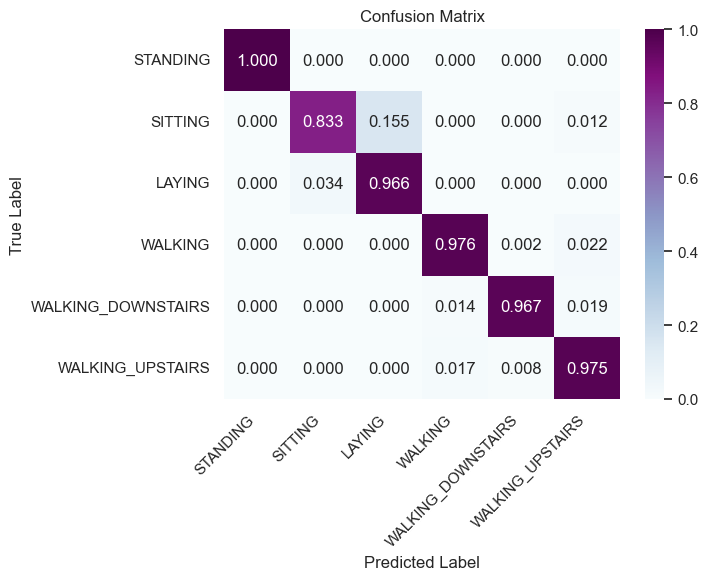

==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9591969403020286


In [76]:
rfepca_svc_grid = GridSearchCV(
    LinearSVC(), param_grid=svc_parameters, cv=3, verbose=1, n_jobs=-1
)
rfepca_svc_grid_results = perform_model(
    rfepca_svc_grid,
    X_train_svc_rfepca,
    y_train,
    X_test_svc_rfepca,
    y_test,
    classes=labels,
    _cm_normalize=True,
    _plot_cm=True,
)

print_grid_search_attributes(rfepca_svc_grid_results["model"])

### Neural Networks


In [114]:
nn_parameters = {
    "epochs": [10, 25],
    "batch_size": [32, 64],
    "optimizer": ["adam"],
    "hidden_layer_dim": [32, 64],
}

In [115]:
def create_model(hidden_layer_dim, meta):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim / 2, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes_, activation="softmax"))
    return model

Base


In [116]:
nn_grid = GridSearchCV(
    KerasClassifier(
        create_model,
        loss="sparse_categorical_crossentropy",
        hidden_layer_dim=32,
        verbose=0,
    ),
    param_grid=nn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1,
)
nn_grid_results = perform_model(
    nn_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(nn_grid_results["model"])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
==> Train time:- 0:03:31.632716
==> Test time:- 0:00:00.268839
==> Accuracy:- 0.9406175771971497
==> F1 Score:- 0.9405443017201277
==> Best parameters:
	Parameters of best estimator : {'batch_size': 32, 'epochs': 25, 'hidden_layer_dim': 64, 'optimizer': 'adam'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9270966452676541


RFE


In [117]:
rfe_nn_grid = GridSearchCV(
    KerasClassifier(
        create_model,
        loss="sparse_categorical_crossentropy",
        hidden_layer_dim=32,
        verbose=0,
    ),
    param_grid=nn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1,
)
rfe_nn_grid_results = perform_model(
    rfe_nn_grid,
    X_train[lr_selected_features],
    y_train,
    X_test[lr_selected_features],
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(rfe_nn_grid_results["model"])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
==> Train time:- 0:01:13.404032
==> Test time:- 0:00:00.151244
==> Accuracy:- 0.9514760773668137
==> F1 Score:- 0.9514029387591983
==> Best parameters:
	Parameters of best estimator : {'batch_size': 64, 'epochs': 25, 'hidden_layer_dim': 32, 'optimizer': 'adam'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9408327019098133


PCA


In [118]:
pca_nn_grid = GridSearchCV(
    KerasClassifier(
        create_model,
        loss="sparse_categorical_crossentropy",
        hidden_layer_dim=32,
        verbose=0,
    ),
    param_grid=nn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1,
)
pca_nn_grid_results = perform_model(
    pca_nn_grid,
    X_train_lr_pca,
    y_train,
    X_test_lr_pca,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(pca_nn_grid_results["model"])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


==> Train time:- 0:00:39.848214
==> Test time:- 0:00:00.135249
==> Accuracy:- 0.9582626399728538
==> F1 Score:- 0.958054356461851
==> Best parameters:
	Parameters of best estimator : {'batch_size': 64, 'epochs': 25, 'hidden_layer_dim': 32, 'optimizer': 'adam'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9430112934606726


VT


In [119]:
vt_nn_grid = GridSearchCV(
    KerasClassifier(
        create_model,
        loss="sparse_categorical_crossentropy",
        hidden_layer_dim=32,
        verbose=0,
    ),
    param_grid=nn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1,
)
vt_nn_grid_results = perform_model(
    vt_nn_grid,
    X_train_vt,
    y_train,
    X_test_vt,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(vt_nn_grid_results["model"])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
==> Train time:- 0:01:49.838494
==> Test time:- 0:00:00.151026
==> Accuracy:- 0.9382422802850356
==> F1 Score:- 0.9379762059390979
==> Best parameters:
	Parameters of best estimator : {'batch_size': 64, 'epochs': 25, 'hidden_layer_dim': 64, 'optimizer': 'adam'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9353932450173051


RFE + PCA


In [120]:
rfepca_nn_grid = GridSearchCV(
    KerasClassifier(
        create_model,
        loss="sparse_categorical_crossentropy",
        hidden_layer_dim=32,
        verbose=0,
    ),
    param_grid=nn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1,
)
rfepca_nn_grid_results = perform_model(
    rfepca_nn_grid,
    X_train_lr_rfepca,
    y_train,
    X_test_lr_rfepca,
    y_test,
    classes=labels,
    _cm_normalize=True,
)

print_grid_search_attributes(rfepca_nn_grid_results["model"])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


==> Train time:- 0:00:41.045713
==> Test time:- 0:00:00.175497
==> Accuracy:- 0.9575839837122497
==> F1 Score:- 0.9575228450663047
==> Best parameters:
	Parameters of best estimator : {'batch_size': 32, 'epochs': 25, 'hidden_layer_dim': 32, 'optimizer': 'adam'}
==> No. of CrossValidation sets:
	Total number of cross validation sets: 3
==> Best Score:
	Average Cross Validate scores of best estimator : 0.9502203459923341
